<a href="https://colab.research.google.com/github/siddadel/kalidas/blob/main/Visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/MyDrive/ANLP21/'
out = root+"out/"

Mounted at /content/drive


In [94]:
import pandas as pd
import random
import os
import re
import spacy
from collections import Counter
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

nlp = spacy.load("en_core_web_sm")
df = pd.read_csv(root+"concatenated-all-characters.csv")

df['item'] = df.apply(lambda row: row['item'].split('{} says, "'.format(row['character']))[1][:-1], axis =1)

df.head()



,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,film,scene,item_ids,item,character,protagonist,xAttr,MotivatedByGoal,xReact
0,10,705912,705912,10_things_i_hate_about_you.txt,1,11,Hey -- sorry.,RIDER,KAT,"[' apologetic', ' remorseful', ' sorry', ' sor...","[' ', ' sorry', ' they are sorry', ' none...","[' sorry', ' relieved', ' sad', ' good', ' hap..."
1,12,705914,705914,10_things_i_hate_about_you.txt,1,13,Leave it,KAT,KAT,"[' independent', ' decisive', ' mean', ' deter...","[' KAT LEAVES IT.', ' KAT LEAVES IT', ' KAT LE...","[' good.', ' satisfied', ' relieved', ' happy'..."
2,18,705920,705920,10_things_i_hate_about_you.txt,2,3,Did you change your hair?,BIANCA,KAT,"[' curious', ' fashionable', ' confident', ' m...","[' PersonY looks at PersonY', ' PersonX looks ...","[' happy.', ' happy', ' curious', ' satisfied'..."
3,19,705921,705921,10_things_i_hate_about_you.txt,2,4,No.,CHASTITY,KAT,"[' decisive', ' determined', ' independent', '...","[' CHASTITY DOES NOT KNOW', ' ', ' CHASTITY'...","[' good.', ' satisfied', ' happy', ' good', ' ..."
4,20,705922,705922,10_things_i_hate_about_you.txt,2,5,You might wanna think about it,BIANCA,KAT,"[' considerate', ' thoughtful', ' curious', ' ...","[' PersonY listens to PersonY', ' PersonY thin...","[' good.', ' good', ' informed', ' happy', ' s..."


In [95]:
df_train =  pd.merge(train_characters, df, on=["film", "character"], how='inner')

In [96]:
df_dev =  pd.merge(dev_characters, df, on=["film", "character"], how='inner')

In [97]:
cf = pd.read_csv(root+'characters-test-train-dev.csv')
# cf['film'] = cf['film'].apply(lambda film: film.replace(".txt.txt.txt.txt.txt.txt.txt",".txt"))

cf1 = cf[cf.apply(lambda row: row['set'] in ['train'], axis=1)] 
train_characters = cf1[['film','character']]

cf2 = cf[cf.apply(lambda row: row['set'] in ['dev'], axis=1)] 
dev_characters = cf2[['film','character']]

print(len(train_characters), len(dev_characters))

184 40


In [98]:
film_char_group = df_train.groupby(['film','character'])

df_film_char_embed = []
for film_char, group in film_char_group:
  df_film_char_embed.append({'film':film_char[0], 'character':film_char[1], 'xAttr': group['xAttr'].apply(lambda x: x.strip('][').lower().strip().split(', ')), 'all_lines': group['item'].str.cat(sep=' '), })

df_film_char_embed = pd.DataFrame(df_film_char_embed)
df_film_char_embed

import itertools
# https://stackoverflow.com/questions/716477/join-list-of-lists-in-python?lq=1
df_film_char_embed['xAttr'] = df_film_char_embed['xAttr'].apply(lambda x: list(itertools.chain.from_iterable(x)))

df_film_char_embed

,film,character,xAttr,all_lines
0,2001_a_space_odyssey.txt,HAL,"[' knowledgeable', ' curious', ' smart', ' int...","I'm sorry, Frank, but I don't think I can answ..."
1,a_nightmare_on_elm_street.txt,NANCY,"[' scared', ' nervous', ' worried', ' frighten...",Matter of fact I had a bad dream last night my...
2,airplane.txt,ELAINE,"[' thoughtful', ' polite', ' grateful', ' frie...","No, but thank you very much. (surprised) Ted! ..."
3,airplane_ii_the_sequel.txt,TED,"[' competent', ' smart', ' responsible', ' bra...","(to self) Next thing I know, I'm the chief tes..."
4,aliens.txt,RIPLEY,"[' weak', ' weak', ' mean', ' careless', ' sad...",(weakly) Terrible. How long have I been on Gat...
...,...,...,...,...
173,what_lies_beneath.txt,CLAIRE,"[' friendly', ' caring', ' kind', ' happy', ' ...","Morning, beauty. Let's go. Or we'll never leav..."
174,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,DOOM,"[' suspicious', ' mean', ' curious', ' violent...",Is this man removing evidence from the scene o...
175,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,JESSICA RABBIT,"[' angry', ' mean', ' rude', ' careless', ' sa...",(sings) 'You had plenty of money back in '22 Y...
176,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,ROGER RABBIT,"[' talkative', ' considerate', ' mean spirited...","Hey, come back! You heard what your mother sa..."


In [89]:
!pip install texthero --quiet

In [99]:
import texthero as hero
df_film_char_embed['tfidf'] = hero.tfidf(df_film_char_embed['all_lines'])

In [100]:
df_film_char_embed

,film,character,xAttr,all_lines,tfidf
0,2001_a_space_odyssey.txt,HAL,"[' knowledgeable', ' curious', ' smart', ' int...","I'm sorry, Frank, but I don't think I can answ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,a_nightmare_on_elm_street.txt,NANCY,"[' scared', ' nervous', ' worried', ' frighten...",Matter of fact I had a bad dream last night my...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,airplane.txt,ELAINE,"[' thoughtful', ' polite', ' grateful', ' frie...","No, but thank you very much. (surprised) Ted! ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,airplane_ii_the_sequel.txt,TED,"[' competent', ' smart', ' responsible', ' bra...","(to self) Next thing I know, I'm the chief tes...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,aliens.txt,RIPLEY,"[' weak', ' weak', ' mean', ' careless', ' sad...",(weakly) Terrible. How long have I been on Gat...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
173,what_lies_beneath.txt,CLAIRE,"[' friendly', ' caring', ' kind', ' happy', ' ...","Morning, beauty. Let's go. Or we'll never leav...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
174,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,DOOM,"[' suspicious', ' mean', ' curious', ' violent...",Is this man removing evidence from the scene o...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
175,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,JESSICA RABBIT,"[' angry', ' mean', ' rude', ' careless', ' sa...",(sings) 'You had plenty of money back in '22 Y...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
176,who_framed_roger_rabbit_who_shot_roger_rabbit.txt,ROGER RABBIT,"[' talkative', ' considerate', ' mean spirited...","Hey, come back! You heard what your mother sa...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



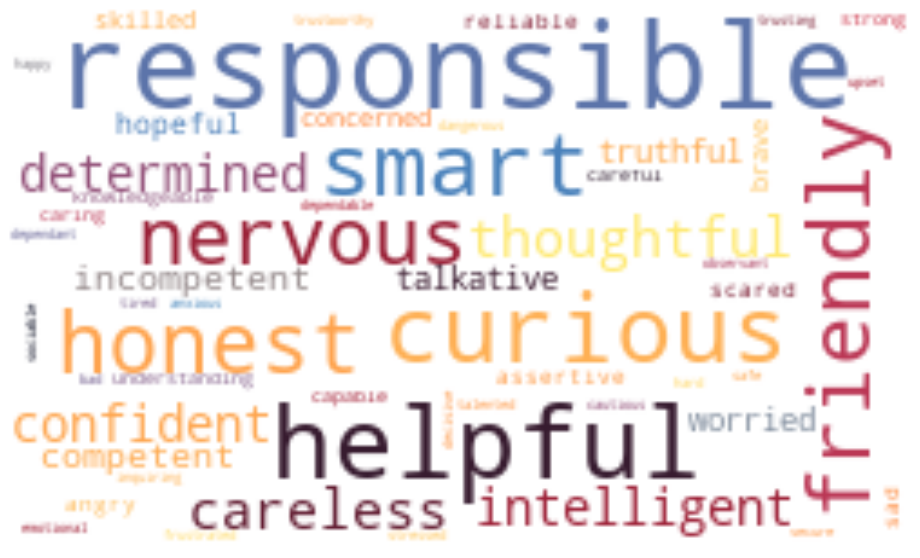

In [101]:
df1 = df_film_char_embed[(df_film_char_embed['film']=="2001_a_space_odyssey.txt") & (df_film_char_embed['character'] == "HAL")]
df1['xAttr'] = hero.clean(df1['xAttr'])
hero.visualization.wordcloud(df1['xAttr'], width= 250, height = 150, max_words=200, background_color='WHITE')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



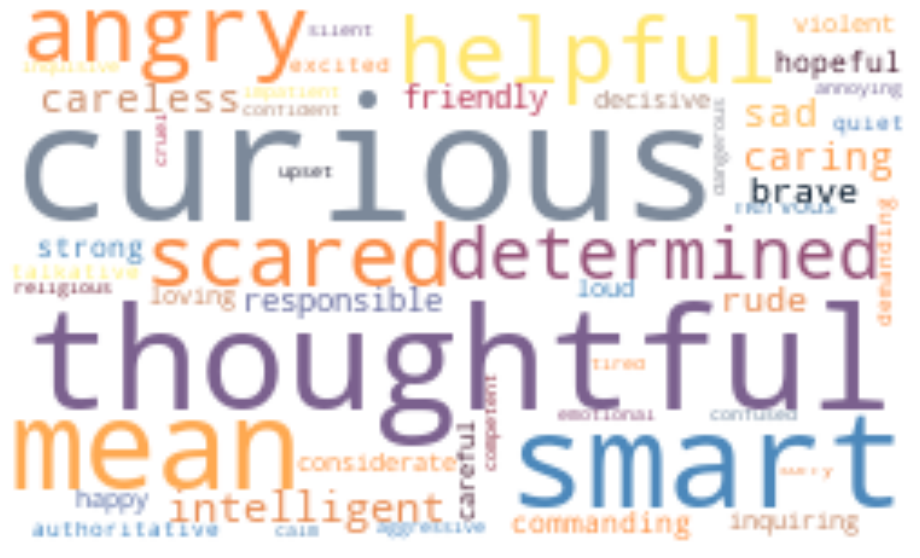

In [102]:
df1 = df_film_char_embed[(df_film_char_embed['film']=="aliens.txt") & (df_film_char_embed['character'] == "RIPLEY")]
df1['xAttr'] = hero.clean(df1['xAttr'])
hero.visualization.wordcloud(df1['xAttr'], width= 250, height = 150, max_words=200, background_color='WHITE')

In [62]:
hero.named_entities(df_film_char_embed['all_lines'], package='spacy')

0      [(Frank, PERSON, 11, 16), (Frank, PERSON, 129,...
1      [(last night, TIME, 33, 43), (Rod, PERSON, 254...
2      [(Ted, PERSON, 41, 44), (Atlanta, GPE, 324, 33...
3      [(XR-2300, ORG, 62, 69), (NASA, ORG, 71, 75), ...
4      [(Gateway, ORG, 43, 50), (Jonesy, LOC, 100, 10...
                             ...                        
173    [(Caitlin, PERSON, 144, 151), (three, CARDINAL...
174    [(Valiant, PERSON, 161, 168), (Maroon, PERSON,...
175    [('22, DATE, 41, 44), (Valiant, PERSON, 410, 4...
176    [(Baby, ORG, 59, 63), (Raoul, PERSON, 117, 122...
177    [(Howard, PERSON, 249, 255), (Howard, PERSON, ...
Length: 178, dtype: object

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



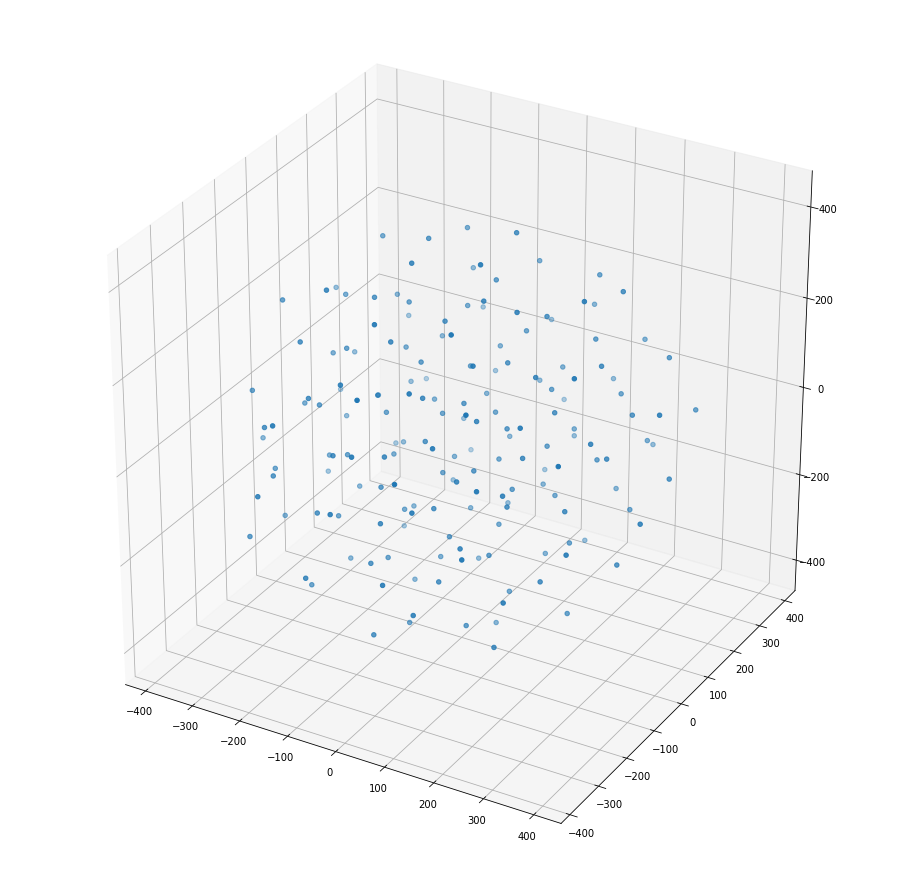

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



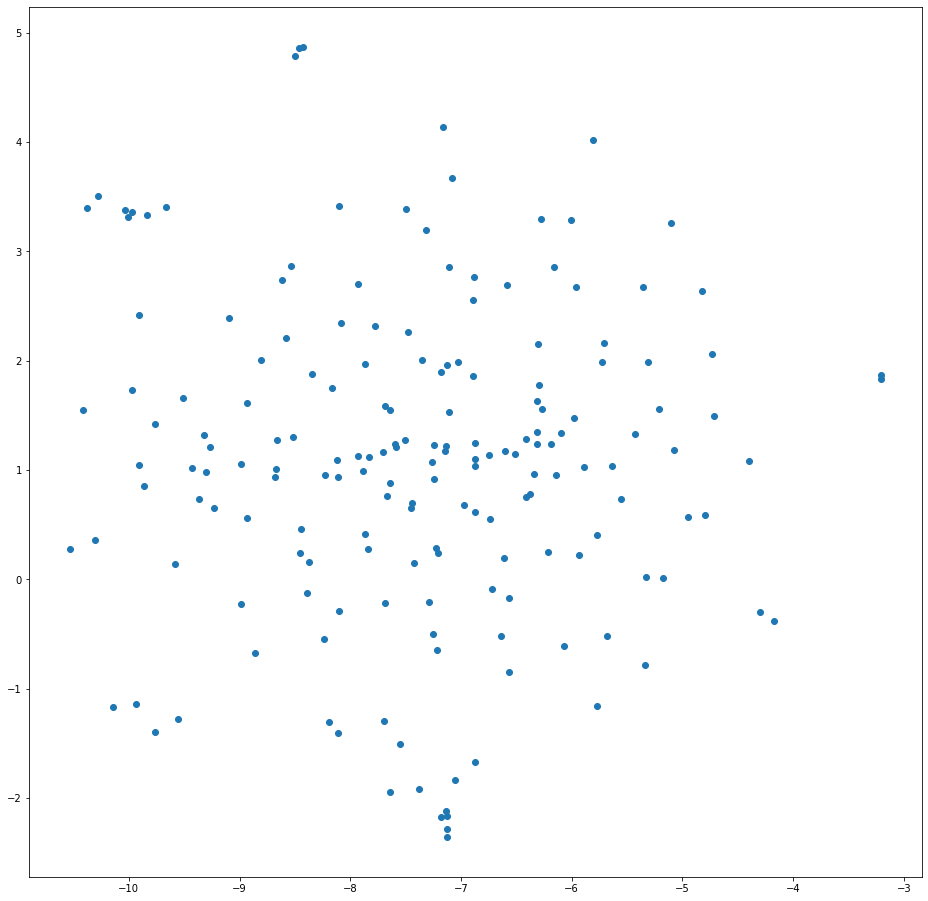

In [55]:
  tsne_model = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(np.array(df_film_char_embed['tfidf'].to_list()))

  x = []
  y = []
  z = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
      z.append(value[2])
          
  plt.figure(figsize=(16, 16)) 
  ax = plt.axes(projection='3d')
  ax.scatter3D(x, y, z, cmap='viridis')
  plt.show()


  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(np.array(df_film_char_embed['tfidf'].to_list()))

  x = []
  y = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
          
  plt.figure(figsize=(16, 16)) 
  plt.scatter(x,y, cmap='viridis')
  plt.show()

KeyError: ignored

In [10]:

relations = [ "xAttr", "xReact"]

In [11]:
# https://stackoverflow.com/questions/61916096/word-cloud-built-out-of-tf-idf-vectorizer-function
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
def visualize_values(texts):
  wordclouds = []
  i = 0
  f, axarr = plt.subplots(1,len(texts), figsize = (40, 30) )
  for text in texts:
    vectorizer = TfidfVectorizer(stop_words='english')
    vecs = vectorizer.fit_transform(text)
    feature_names = vectorizer.get_feature_names_out()
    dense = vecs.todense()
    lst1 = dense.tolist()
    df = pd.DataFrame(lst1, columns=feature_names)
    x = vectorizer.vocabulary_
    wordcloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))

    axarr[i].imshow(wordcloud, interpolation = 'bilinear')
    i+=1

def visualize_character(film, character):
  df1 = df[(df['film']==film) & (df['character'] == character)]
  visualize_values([df1[relation].to_list() for relation in relations])
  

def visualize_cluster(df, cluster):
  df1 = df[df['cluster']==cluster]
  visualize_values([df1[relation].to_list() for relation in relations])

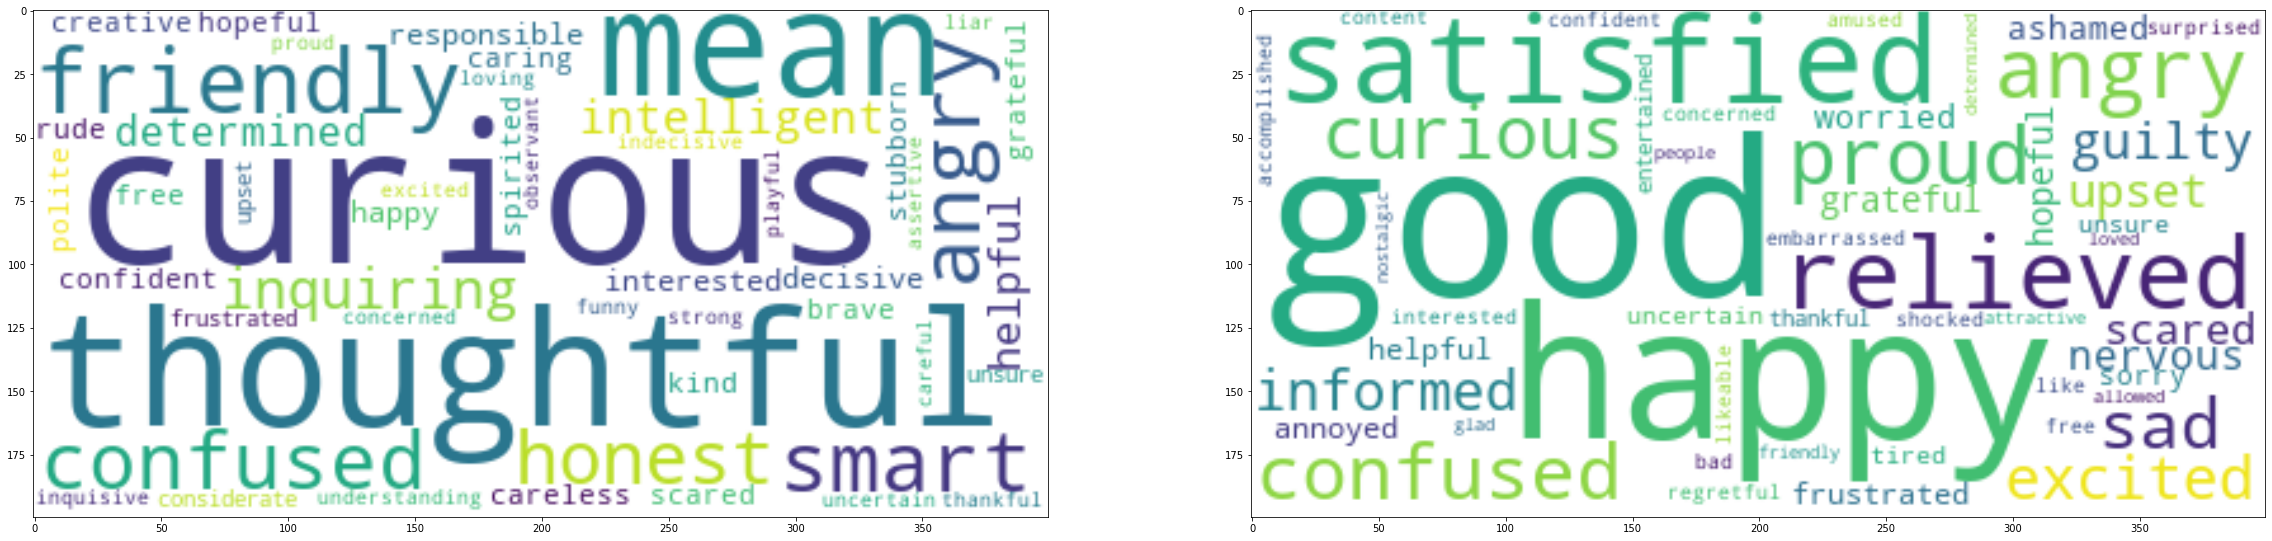

In [12]:
	visualize_character("the_majestic.txt", "PETE")

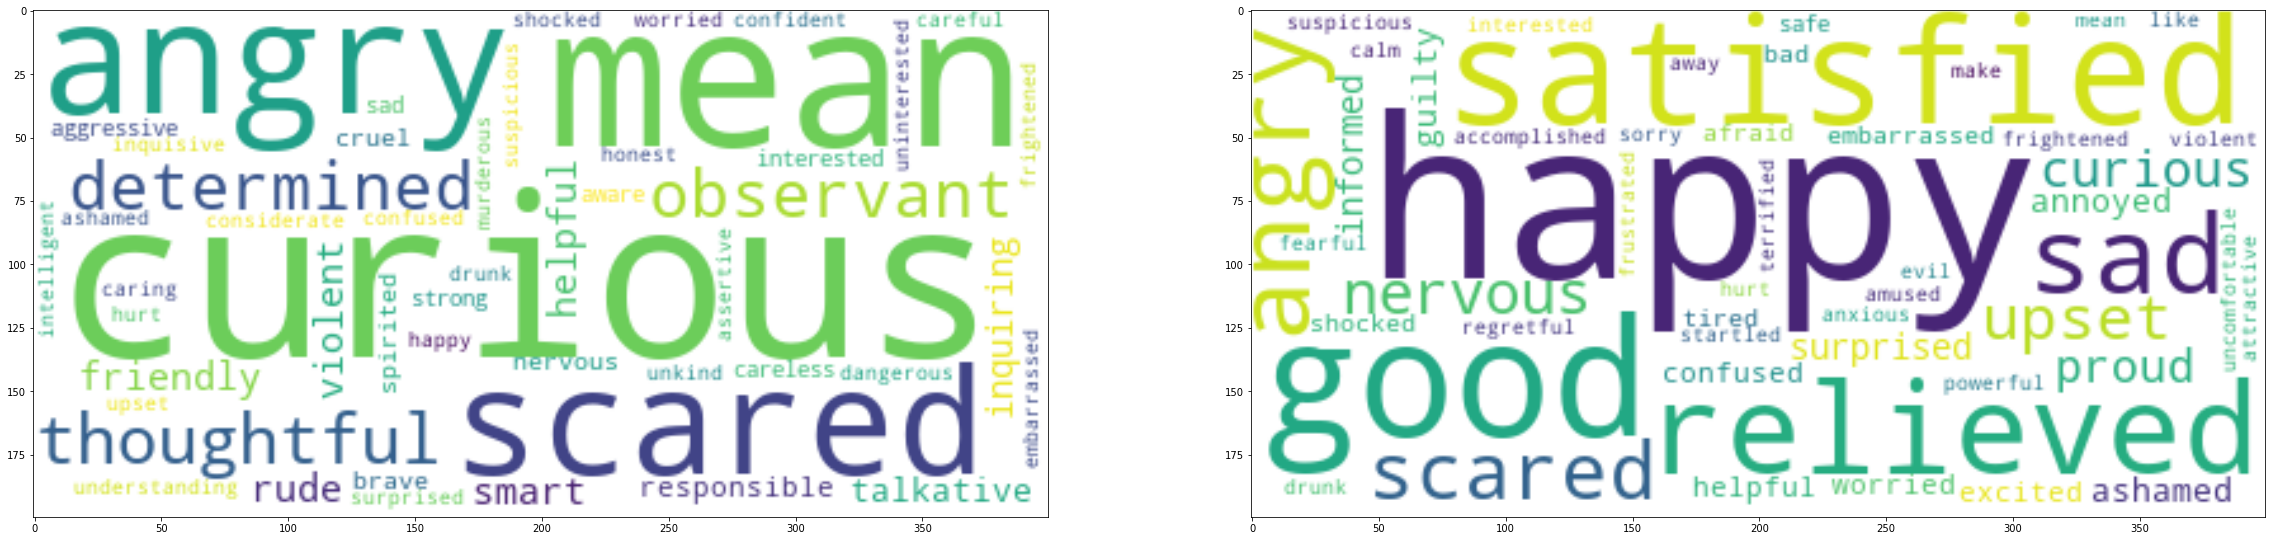

In [13]:
visualize_character("unforgiven.txt", "MUNNY")

In [ ]:
visualize_character("the_godfather_part_2.txt", "MICHAEL") 

In [ ]:
visualize_character("south_park_bigger_longer_uncut.txt", "MR. GARRISON (AS MR. HAT)") 

In [ ]:
visualize_character("the_english_patient.txt", "HANA") 

In [ ]:
df_train